In [1]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as web
import plotly.graph_objects as go

In [179]:

# ticker = input("Enter Ticker Symbol: ")
# tickerAnalysis(ticker)
# tickers = [']


def tickerAnalysis(ticker):
    finviz_url = 'https://finviz.com/quote.ashx?t='
    news_tables = {}
    
    
    url = finviz_url+ticker
    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)
    html = BeautifulSoup(response, 'html')
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table



    parsed_data = []

    for ticker, news_table in news_tables.items():
        for row in news_table.findAll('tr'):
            title = row.a.get_text()
            date_data = row.td.text.split(' ')
            if len(date_data) == 1:
                time = date_data[0]
            else:
                date = date_data[0]
                time = date_data[1]


            parsed_data.append([ticker, date, time, title])


    df = pd.DataFrame(parsed_data, columns = ['Ticker', 'Date', 'Time', 'Title'])


    vader = SentimentIntensityAnalyzer()

    f = lambda title: vader.polarity_scores(title)['compound']
    df['Compound'] = df['Title'].apply(f)
    df['Date'] = pd.to_datetime(df.Date).dt.date
    
    
    s = df['Date']
    size = len(df['Date'])
    start_date = s[size-1]


    plt.figure(figsize = (20,18))

    mean_df = df.groupby(['Ticker', 'Date']).mean()
    mean_df = mean_df.unstack()
    mean_df = mean_df.xs('Compound', axis='columns').transpose()

    
    mean_df.plot(kind = 'line')
    print(mean_df.iloc[:,0])
    stock_chart(ticker, start_date, mean_df)
    


In [186]:
def stock_chart(tick, start_date, mean_df):
    stock = tick

    df = web.DataReader(stock, data_source='yahoo', start=start_date)

    trace1 = {
        'x': df.index,
        'open': df.Open,
        'close': df.Close,
        'high': df.High,
        'low': df.Low,
        'type': 'candlestick',
        'name': stock,
        'showlegend': True
    }




#     # Calculate and define moving average of 30 periods
#     avg_30 = df.Close.rolling(window=30, min_periods=1).mean()

#     # Calculate and define moving average of 50 periods
#     avg_50 = df.Close.rolling(window=50, min_periods=1).mean()

    trace2 = {
        'x': mean_df.index,
        'y': (mean_df.iloc[:,0] + 1) * df.Close,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'blue'
                },
        'name': 'Moving Average of 30 periods'
    }

#     trace3 = {
#         'x': df.index,
#         'y': avg_50,
#         'type': 'scatter',
#         'mode': 'lines',
#         'line': {
#             'width': 1,
#             'color': 'red'
#         },
#         'name': 'Moving Average of 50 periods'
#     }

    data = [trace1, trace2]
    # Config graph layout
    layout = go.Layout({
        'title': {
            'text': stock+' Moving Averages',
            'font': {
                'size': 15
            }
        }
    })


    fig = go.Figure(data=data, layout=layout)
    fig.write_html(stock+" Moving Averages.html")
    fig.show()


Enter Stock Symbol: fsr
Date
2020-12-14    0.153100
2020-12-15    0.000000
2020-12-17    0.136600
2020-12-21    0.000000
2020-12-23    0.296000
                ...   
2021-06-01    0.000000
2021-06-02    0.000000
2021-06-03    0.038600
2021-06-04    0.200950
2021-06-07    0.164633
Name: fsr, Length: 66, dtype: float64


<Figure size 1440x1296 with 0 Axes>

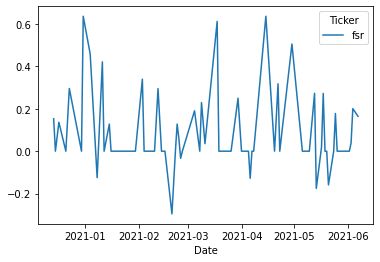

In [187]:
ticker = input("Enter Stock Symbol: ")
tickerAnalysis(ticker)
